# 07 - Modeling Notebook

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from yellowbrick.classifier import ROCAUC


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import logging
from datetime import datetime
from datetime import timedelta

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore', category=DataConversionWarning)
simplefilter(action="ignore", category=SettingWithCopyWarning)
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=DeprecationWarning) 

import sweetviz as sv
import matplotlib.pyplot as plt
import json
import tqdm
from tqdm import tqdm_notebook as tqdm_final

import pickle

In [3]:

# check pycaret version
import sklearn as sklearn
print('PyCaret: %s' % sklearn.__version__)

PyCaret: 0.23.2


In [4]:
import mytransformer as myt

In [5]:
# create the log for this Notebook
now = datetime.now()
filename = 'logs/07-Modeling-' + now.strftime("%m%d%Y") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('')
logging.info('***************************************************************************************************')
logging.info('***                                                                                             ***')
logging.info('***   NEW RUN                                                                                   ***')
logging.info('***                                                                                             ***')
logging.info('***************************************************************************************************')

logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))


In [6]:
# folder = '../../data source/_anonymized/'
# declare some constants
folder = '_anonymized/'
sweetviz = True

In [7]:
# read the cleaned csv files

df = pd.read_csv(folder + 'dataset_4_modelling.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('Unnamed: 0 not existing in this file.')
    
logging.info('{} rows and {} columns read in the CSV file'.format(df.shape[0], df.shape[1]))
df.shape

(8902, 67)

# Test the CustomTransformer
The CustomTransformer is importedas a library. The next cells tests the call to the transformation with a sample configuration file.

In [8]:
# Create X and y
X = df.drop('TARGET', axis=1)
y = df.TARGET

# define columns which will passed to transformer for the grouping (brk)
# when applying method such as shift or expanding, I want to maintain the
# fund grouping (or other attribute to set in brk).

brk='SRC_UID'


# Read configuration file
try:
    with open('config_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=True))]
transformation_pipeline = Pipeline(steps)

test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)

In [9]:
new_features = ['SRC_UID','FLOWS_YEAR','FLOWS_MONTH']
new_features =new_features + [x for x in test_transformed_pipeline.columns if 's' in x or 'r' in x or 'e' in x or 'x' in x  ]
test_transformed_pipeline[new_features]

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,AUM-r2,AUM-r5,AUM-r7
0,206670688,2010,1,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08
1,206670688,2010,2,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08
2,206670688,2010,3,89408248.0,69669121.0,69669121.0,673792629.5,654958566.2,6.137747e+08
3,206670688,2010,4,68084125.0,89408248.0,69669121.0,634908810.0,654958566.2,6.137747e+08
4,206670688,2010,5,104779215.0,68084125.0,89408248.0,610520193.5,654958566.2,6.137747e+08
...,...,...,...,...,...,...,...,...,...
8897,213479867994200,2020,9,2226192.0,7838181.0,14258055.0,499453583.0,466825279.2,4.407168e+08
8898,213479867994200,2020,10,8479346.0,2226192.0,7838181.0,509903678.0,489066372.0,4.679802e+08
8899,213479867994200,2020,11,14776729.0,8479346.0,2226192.0,547350187.0,516972277.8,4.898324e+08
8900,213479867994200,2020,12,24501245.0,14776729.0,8479346.0,605626878.0,546329817.0,5.223694e+08


# Capstone Project
## Modelling

The modelling will implement classification models from Sklearn and evaluate the prediction. Prior to implement model, I will decide the metrics I will used to evaluate the modelling process.

As in the previous Notebooks I prepared the dataset and created a personal transformer I will use it in the modelling pipeline with some other transformation such as “power transformation”.

The modelling notebook will implement:
1.	Decide metrics
2.	Prepare configuration file for the personal transformer
3.	Split the dataset
a.	Beginning -> 2019 training set
b.	2020 -> validation set
c.	2021 -> test set
4.	Compute a baseline
a.	Baseline will be done on a minimal dataset transformation
5.	Create pipelines
a.	Pre-processing steps
i.	Scaling
ii.	Adding PolynomialFeatures
iii.	OneHotEncoding
iv.	36tEncoding
b.	Custom transformation
c.	Classifiers
6.	Run the modelling step with pipelines
7.	Select the best estimator
8.	Fine tune the best estimator
9.	Run the fine tunned estimator on the test set
10.	Present and discuss the results

Everything will be implemented mostly with scikit learn (https://scikit-learn.org/stable/user_guide.html)
### Metrics
I will work with 6 classification problems metrics to evaluate the performance of the models. Metrics are: Accuracy score, confusion matrix (3x3), Precision, Recall, F1 score and ROC Curve.
1.	https://towardsdatascience.com/a-practical-guide-to-seven-essential-performance-metrics-for-classification-using-scikit-learn-2de0e0a8a040
2.	https://towardsdatascience.com/6-useful-metrics-to-evaluate-binary-classification-models-55fd1fed6a20

#### ROC Curve
The ROC Curve will shows the tru positive rate against the false positive. The perfect classification represented by (0,1) will shows how the model how the model classify positives without missclassifying negative as positive.

For this metrics I installed <i>yellowbrick</i> (https://www.scikit-yb.org/en/latest/) which has a ready to use method for multiclass ROC AUC plots that is very easy.

- https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de#:~:text=For%20multiclass%20problems%2C%20ROC%20curves,calculated%20for%20each%20class%20individually.
- https://medium.com/analytics-vidhya/understanding-roc-and-auc-metrics-in-classification-tasks-e5e7594cd6b

### Configuration files for the custom transformer
I will prepare 4 configuration files. The 1st one will be a minimal file to evaluate a simple baseline. It will shift the net flows for 1, 2 and 3 periods.

The other configuration files will be more complicated. 2 will be based on the analysis and recommendation from the EDA Notebooks and the last one will a massive choice of features.

### Split the dataset
I decided to split my dataset in a training set [< 2020], a validation set [=2020] and a test set [=2021]. I will verify the balance of the target data after splitting the dataset.

### Pipelines
In the pipelines I will add pre-processing step, optional steps (as we did in the course) and transformation. I will use a grid search to evaluate multiple configurations of parameters.
1.	https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

#### Models
•	Logistic Regression (which is a linear model for classification problems).
•	Support Vector Machine: (https://scikit-learn.org/stable/modules/svm.html)
•	Nearest Neighbours Classification: (https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
•	Decision Trees Classification: (https://scikit-learn.org/stable/modules/tree.html#classification)
•	Neural Network Models (supervised) Classification: (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)

A meta estimator which fits several decision trees:
•	Random Forest Classifier: (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

I will run a grid search over multiple classifiers to elicit the best estimator.
https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers
### Best estimator, fine tuning, and test set evaluation
At the end of the pipeline process, I will decide the best estimator, fine tune some parameters if needed and evaluate it against un unknown dataset which is the 2021 entry values (almost all Q1 data).





# Split my dataset
I decided to split my dataset as following:

- training set (all data before 2020)
- validation set (all data of 2020)
- test set (all data of 2021)

## Check if split is well distributed
I will check and plot if the data after split are well distributed within the target value.

I define 3 filters which I will apply to the full dataset. Then I will create 3 set and evaluate for each of them the ratio of:
- in flows
- no flows
- out flows

In [10]:
split_df = df.copy()

In [11]:
f_training = split_df.FLOWS_YEAR < 2019
f_validation = (split_df.FLOWS_YEAR == 2019) 
f_test = (split_df.FLOWS_YEAR > 2019) 
f_trainval = (split_df.FLOWS_YEAR < 2020) 

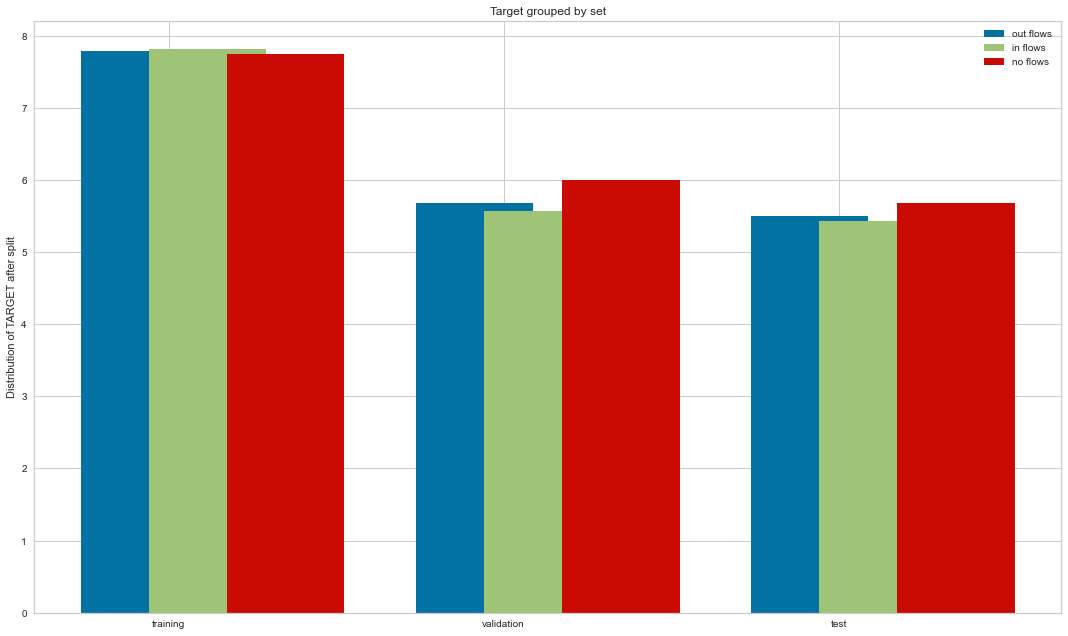

In [12]:
target_distrib = {}
# distribution of test set
(unique, counts) = np.unique(split_df.loc[f_test,'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['test']=frequencies
# distribution of validation set
(unique, counts) = np.unique(split_df.loc[f_validation,'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['validation']=frequencies
# distribution of training set
(unique, counts) = np.unique(split_df.loc[f_training,'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['training']=frequencies




labels = ['training', 'validation', 'test']
out_flows = np.log([target_distrib['training'][0][1], target_distrib['validation'][0][1], target_distrib['test'][0][1]])
no_flows = np.log([target_distrib['training'][1][1], target_distrib['validation'][1][1], target_distrib['test'][1][1]]) 
in_flows =np.log([target_distrib['training'][2][1], target_distrib['validation'][2][1], target_distrib['test'][2][1]])

x = np.arange(len(labels))  # the label locations
width =0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(15,9))

rects1 = ax.bar(x - width/4, out_flows, width, label='out flows')
rects3 = ax.bar(x + width/3, in_flows, width, label='in flows')
rects2 = ax.bar(x + width/1, no_flows, width, label='no flows')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distribution of TARGET after split')
ax.set_title('Target grouped by set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout()

plt.show()

In [13]:
print(df.loc[:,['TARGET','SRC_UID']].groupby('TARGET').count())

        SRC_UID
TARGET         
-1         2944
 0         2994
 1         2964


In [14]:
# define a function which will be called to split the dataset
def split_dataset(df):
    split_df = df.copy()
    f_training = split_df.FLOWS_YEAR < 2019
    f_validation = (split_df.FLOWS_YEAR == 2019) 
    f_test = (split_df.FLOWS_YEAR > 2019) 
    f_trainval = (split_df.FLOWS_YEAR < 2020) 
    
    X_train = split_df.loc[f_training,:].drop('TARGET', axis=1)
    y_train = split_df.loc[f_training,'TARGET']
    
    X_validation = split_df.loc[f_validation,:].drop('TARGET', axis=1)
    y_validation = split_df.loc[f_validation,'TARGET']
    
    X_test = split_df.loc[f_test,:].drop('TARGET', axis=1)
    y_test = split_df.loc[f_test,'TARGET']
    
    X_trainval = split_df.loc[f_trainval,:].drop('TARGET', axis=1)
    y_trainval = split_df.loc[f_trainval,'TARGET']
    '''
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_trainval, y_trainval, test_size=0.33, random_state=42, stratify=y_trainval)    
    '''
    logging.info('dataset split called')
    return X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval
    

## Split Observation
The split gives balanced set related to the target variables.

In [15]:


X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape



# define columns which will passed to transformer for the grouping (brk)
# when applying method such as shift or expanding, I want to maintain the
# fund grouping (or other attribute to set in brk).

brk='SRC_UID'


# Read configuration file
try:
    with open('config_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=True))]
transformation_pipeline = Pipeline(steps)

test_transformed_pipeline = transformation_pipeline.fit(X_trainval, y_trainval)


train_val_df = transformation_pipeline.transform(X_trainval )

test_df = transformation_pipeline.transform(X_test )

train_val_df.shape, test_df.shape

((8139, 72), (763, 72))

# Metrics report
I wite a simple function to display modeling report. The function receive the target value fot the validation set and the predicted value (y_validation, y_pred) and displays results.

In [16]:
def metrics_report(y_validation, y_pred):
    # confusion matrix
    confusion = confusion_matrix(y_validation, y_pred)
    print('Confusion Matrix\n')
    print(confusion)
    logging.info('Confusion Matrix \n {}'.format(confusion))

    # accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_validation, y_pred)))
    logging.info('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_validation, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, y_pred, average='weighted')))


    print('\nClassification Report\n')
    print(classification_report(y_validation, y_pred, target_names=['Out Flows', 'NeutralFlows', 'In Flows']))
    
    return accuracy_score(y_validation, y_pred), confusion

In [17]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={-1: 'Out flows', 
                                        0: 'no flows / neutral', 
                                        1: 'in flows'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

# Modelling Concept
In the previous Notebooks I explored the data, make a review of the time series and build a CustomTransformer which help to adopt rolling window and other shifting method to transform the TS to a supervised learning dataset.

<b>Time to apply these methods to the modelling steps of my project !</b>

The concept is to extract features from the full dataset and apply Custom Transormation to get a subset of features. This subset will be arranged in a area for the traning/validation process and finally the test set (data that has not been involded in the training and evaluation process).

The the modeling can be applied with different steps such as data pre-processing, features selections, features engineering (power transformation), dimensionality reduction and other method. I will mostly work with pipelines and grid search method.

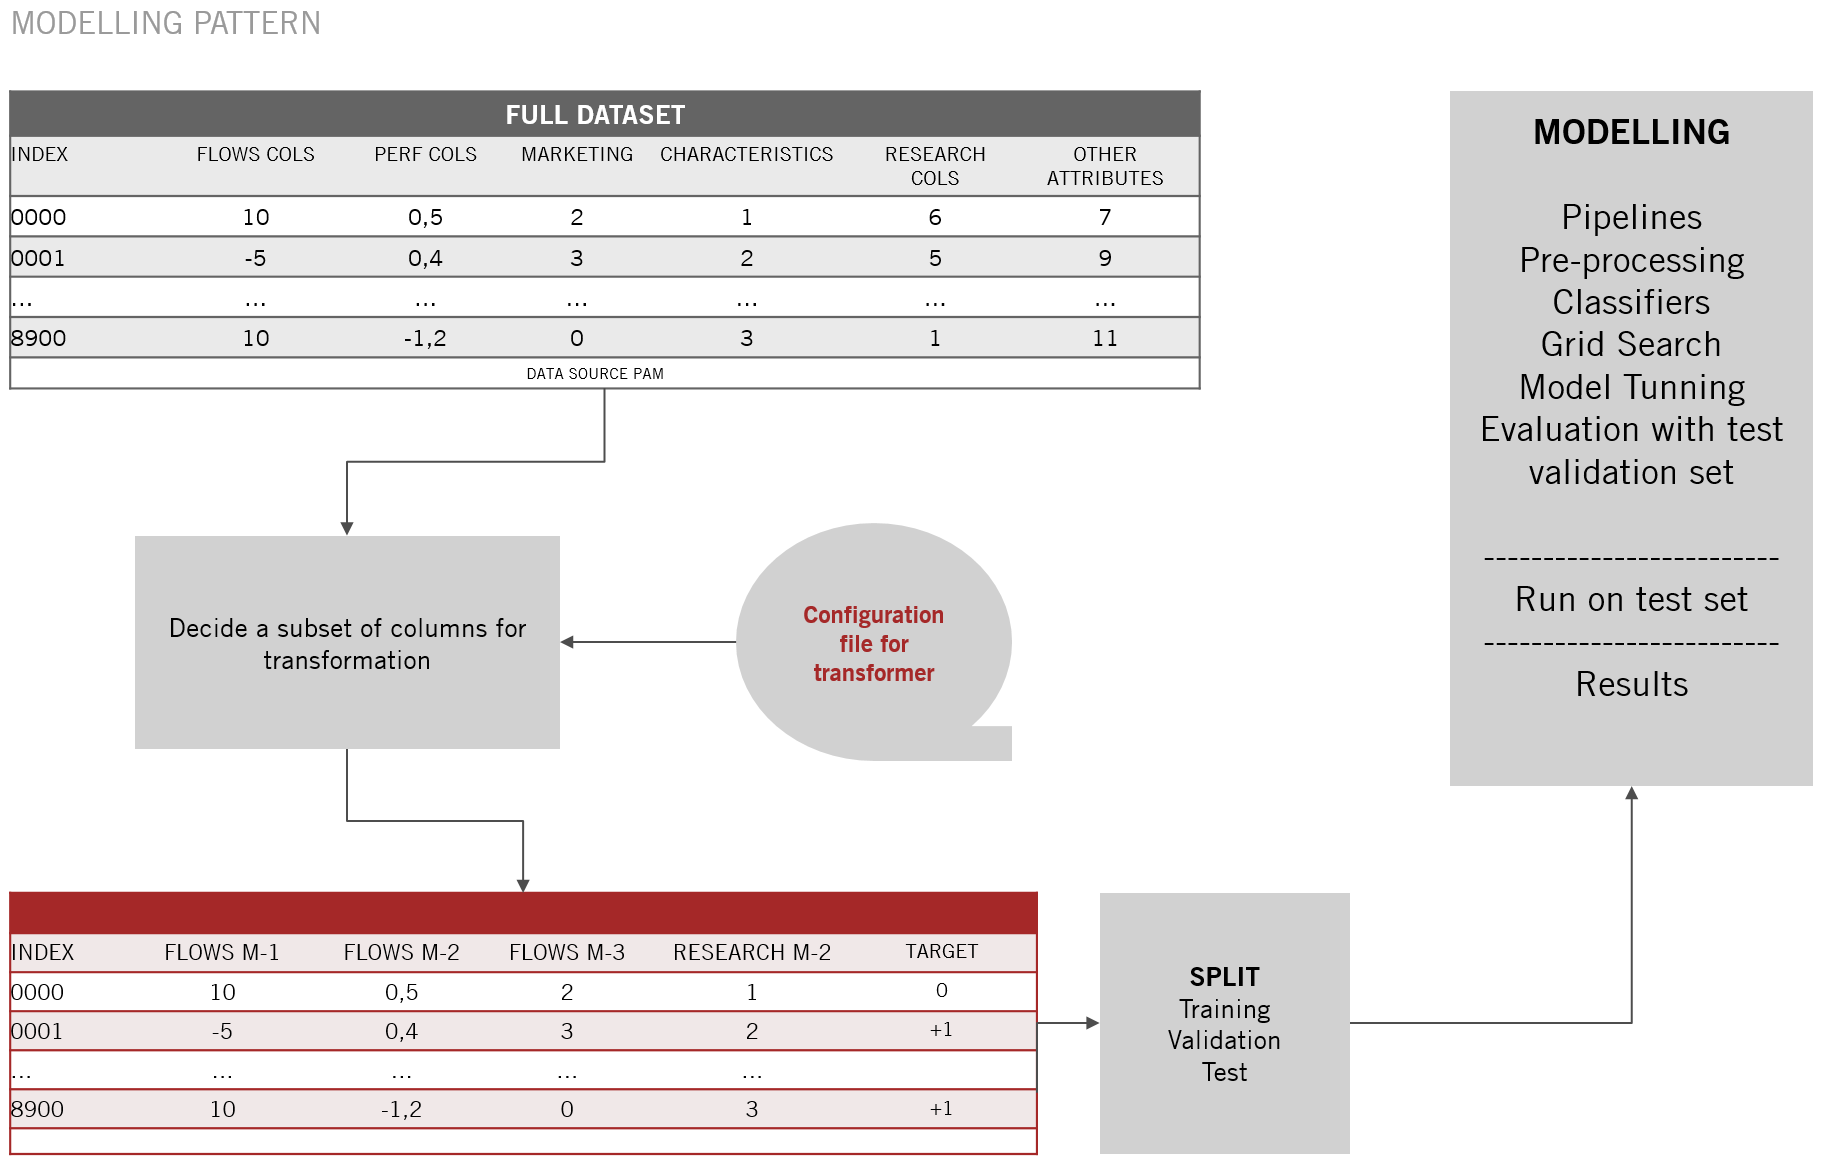

# Baseline
I will compute a baseline by extracting the net flows and apply a custom transformation to shift the feature over 3 periods (m-3, m-2, m-1). In the baseline I will add the nav/benchmark performance slope and nav/bench volatility slope.
As a standard I will always add the <i>flows_yeays</i> and <i>flows_month</i> in the dataset.

In [29]:
# create a temporary dataset for the baseline modelling
# I make a copy of specif columns from the full dataset to a baseline dataset
baseline_features = ['SRC_UID','FLOWS_YEAR','FLOWS_MONTH','BENCH_PERF_SLOPE',
       'BENCH_VOL_SLOPE', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE','AUM', 'TARGET','NET_FLOWS']
baseline_df = df[baseline_features].copy()
baseline_df.head()

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,BENCH_PERF_SLOPE,BENCH_VOL_SLOPE,NAV_PERF_SLOPE,NAV_VOL_SLOPE,AUM,TARGET,NET_FLOWS
0,206670688,2010,1,-0.002294,-0.000033,-0.001929,-0.000154,706167185,-1,-131827306
1,206670688,2010,2,-0.001882,-0.000032,-0.001646,-0.000127,721513696,1,15097645
2,206670688,2010,3,-0.001614,-0.000034,-0.001485,-0.000106,626071563,-1,-95518684
3,206670688,2010,4,-0.001358,-0.000022,-0.001052,-0.000082,643746057,1,17638095
4,206670688,2010,5,-0.001117,-0.000016,-0.000743,-0.000062,577294330,-1,-66598477


In [30]:
# split
X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(baseline_df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape



((7185, 9), (7185,), (954, 9), (954,), (763, 9), (763,))

In [31]:
# define the configuration dictionary for the baseline
# I will only shift the NET FLOWS for 3 periods
# Remove the NET_FLOWS columns
trans = []
dico= {}
dico['cols'] = ['BENCH_PERF_SLOPE',
       'BENCH_VOL_SLOPE', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE','AUM','NET_FLOWS']
dico['method'] = 'shift'
dico['period'] = [1]
dico['original'] = False
trans.append(dico)

# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
baseline_pipeline = Pipeline(steps)

baseline_transformed_pipeline = baseline_pipeline.fit(X_trainval, y_trainval)

train_val_df = baseline_pipeline.transform(X_trainval).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()
test_df = baseline_pipeline.transform(X_test).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()

In [32]:
X_trainval = train_val_df.drop('TARGET', axis=1).values
y_trainval = train_val_df.TARGET.values

X_test = test_df.drop('TARGET', axis=1).values
y_test = test_df.TARGET.values

In [33]:
np.unique(y_test, return_counts=True),  np.unique(y_trainval, return_counts=True)

((array([-1,  0,  1], dtype=int64), array([220, 265, 202], dtype=int64)),
 (array([-1,  0,  1], dtype=int64), array([2677, 2681, 2700], dtype=int64)))

###### Create the pipelines with simple scaling and classifiers

In [40]:
# create a pipeline for the baseline
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('LR',LogisticRegression(solver='liblinear', random_state=42))])))
pipelines.append(('SVM', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('SVC',SVC(gamma='auto', random_state=42))])))
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('KNN',KNeighborsClassifier())])))
pipelines.append(('TREE', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('TREE',DecisionTreeClassifier(random_state=42))])))
pipelines.append(('FOREST', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('FOREST',RandomForestClassifier(random_state=42))])))
pipelines.append(('MLP', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('MLP',MLPClassifier(max_iter=500,solver='lbfgs'))])))

In [41]:
from sklearn.model_selection import cross_validate
def run_pipelines(X_trainval, y_trainval):
    # Test options and evaluation metric
    num_folds = 5
    seed = 7
    scoring = 'accuracy'
    
    
    X_trainval=X_trainval.astype('float64')
    y_trainval=y_trainval.astype('float64')


    results = []
    names = []
    msgs = []

    with tqdm.tqdm(total=len(pipelines)) as pbar:
        for name, model in pipelines:
            try:
                kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
                cv_results = cross_val_score(model, X_trainval, y_trainval, cv=kfold, scoring=scoring)
                results.append(cv_results)
                names.append(name)
                msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
                msgs.append(msg)
                logging.info(msg)
                scores = cross_validate(model, X_trainval, y_trainval, cv=kfold, return_train_score=True)
                print('Train scores:', scores['train_score'].mean()) # [0.98 1. 1.]
                print('Test scores:', scores['test_score'].mean()) # [0. 0. 0.]
            except:
                logging.warning('UNABLE TO RUN THE CROSS VAL')
            pbar.update(1)


    print(msgs)
    return results, names


scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
y_trainval_scaled = (y_trainval)


results, names = run_pipelines(X_trainval_scaled, y_trainval_scaled)

 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.32s/it]

Train scores: 0.45079419141186106
Test scores: 0.4446508418395245


 33%|████████████████████████████                                                        | 2/6 [00:28<01:06, 16.66s/it]

Train scores: 0.5150161360097881
Test scores: 0.45668904692152135


 50%|██████████████████████████████████████████                                          | 3/6 [00:35<00:36, 12.15s/it]

Train scores: 0.631018667643052
Test scores: 0.4435369120177194


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:38<00:16,  8.44s/it]

Train scores: 1.0
Test scores: 0.4259124228127652


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:56<00:11, 11.90s/it]

Train scores: 1.0
Test scores: 0.4955321895220976


C:\Users\resqu\AppData\Roaming\Python\Python36\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\resqu\AppData\Roaming\Python\Python36\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\resqu\AppData\Roaming\Python\Python36\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs

Train scores: 0.6130860568098621
Test scores: 0.4544562583848942
['LR: 0.444651 (0.011236)', 'SVM: 0.456689 (0.001576)', 'KNN: 0.443537 (0.008966)', 'TREE: 0.425912 (0.010346)', 'FOREST: 0.495532 (0.007107)', 'MLP: 0.453213 (0.007549)']


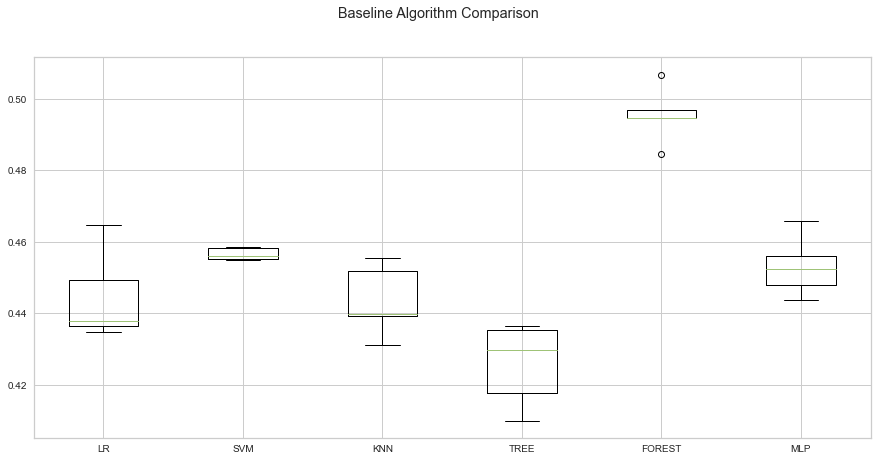

In [42]:
# Compare Algorithms
fig = plt.figure(figsize=(15,7))
fig.suptitle('Baseline Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Baseline observations
The score are in a small window and we cannot cleary eliminate a classifier or select a specific one..

# Evaluate a configuration transformation

The Time Series dataset can be transformed with my Custome Transformer by applying windowing to features. To recall, the methods are shift, rolling, expanding and ewm (exponential weighted).

The function bellow receives a configuration paramter set, transforms the Time Series dataset to a supervised learning dataset, splits the data (2010 - mid-2019, mid-2019 to mid-2020, mid-2020 to now) and finally runs the pipeline with differents classifiers.



In [24]:
show_boxplot=False

In [25]:
def plot_evaluation(results, names):
    # Compare Algorithms
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Modeling Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

def evaluate_transformation_TS_2_SL(config, cols, interpolate, show_plot):
    evaluated_df = df[cols].copy()

    #X = evaluated_df.drop(['TARGET','FLOWS_YEAR','FLOWS_MONTH'], axis=1)
    #y = evaluated_df.TARGET
    
    X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(evaluated_df)
    X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape   
    
    
    # create the steps and the transformation Pipeline
    steps = [('ts_2_supervised',myt.TS2Supervised(transformation=config, breakdown=brk
                                              , verbose=False, interpolation=interpolate))]
    # create
    evaluated_pipeline = Pipeline(steps)

    evaluated_transformed_pipeline = evaluated_pipeline.fit(X_trainval, y_trainval)
    train_val_df = evaluated_pipeline.transform(X_trainval).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()
    test_df = evaluated_pipeline.transform(X_test).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()

    X_trainval = train_val_df.drop('TARGET', axis=1).values
    y_trainval = train_val_df.TARGET.values

    X_test = test_df.drop('TARGET', axis=1).values
    y_test = test_df.TARGET.values
    
    #evaluated_df = evaluated_transformed_pipeline.merge(df[['TARGET','FLOWS_YEAR','FLOWS_MONTH']], left_index=True, right_index=True).copy()
    #evaluated_df.dropna(inplace=True)
    #evaluated_df    
    
    #X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(evaluated_df)
    #print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
    
    results, names = run_pipelines(X_trainval, y_trainval)
    logging.info('MODEL-Evaluated My Choice features with rolling on FLOWS {}'.format(len(cols)-4))
    logging.info('Results: \n\n{}'.format(results))
    logging.info('--------------------------------------------------------------------------------------------------') 
    
    if show_plot:
        plot_evaluation(results, names)
    
    return results, names, X_train, y_train

In [26]:
global_results_set = []

## Transformer n° 1 -- SelectKBest --
For the 1st transformer I will work with sklearn SelectKBest to identify x best features and evalute classifiers.

In [27]:
df.shape

(8902, 67)

In [28]:
n_features_list=[20,35,45]

for n_features in n_features_list:
    # define the X vector and y target for the new temprary dataset
    features_df = df.drop(['NET_FLOWS','COMPUTED_FLOWS','SRC_UID','THRESHOLD'], axis=1).copy()
    target = df.TARGET

    X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(features_df)
    # X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

    # Create and fit selector

    selector = SelectKBest(f_classif, k=n_features)

    # selector.fit(features_df, target)
    selector.fit(X_train, y_train)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    

    features_df_new = features_df.iloc[:,cols]
    
    try:
        features_df_new.drop('SRC_UID',axis=1, inplace=True)
    except:
        None
    try:
        features_df_new.drop('TARGET',axis=1, inplace=True)
    except:
        None

    features_df_new=features_df_new.merge(df[['SRC_UID','TARGET']], left_index=True, right_index=True)

    cols_config=features_df_new.drop(['SRC_UID','TARGET'],axis=1).columns.tolist()
    
    print(cols_config)
    if 'FLOWS_MONTH' in cols_config:
        cols_config.remove('FLOWS_MONTH')
    if 'FLOWS_YEAR' in cols_config:
        cols_config.remove('FLOWS_YEAR')
        


    X = features_df_new.drop('TARGET', axis=1)
    y = features_df_new.TARGET

    trans = []
    for i in range(len(cols_config)):
        dico= {}
        dico['cols'] = [cols_config[i]]
        dico['method'] = 'rolling'
        dico['period'] = [2,3,6]
        dico['original'] = False
        trans.append(dico)

    trans
    eval_cols=features_df_new.columns.tolist()
    eval_cols.append('FLOWS_YEAR')
    eval_cols.append('FLOWS_MONTH')

    r, n, _, _ = evaluate_transformation_TS_2_SL(trans, eval_cols, False, show_boxplot)
    i=0
    for j in r:
        global_results_set.append([names[i], j.mean(), trans, eval_cols,'{} features SelectKBest'.format(n_features),'Transformer-1'])
        i=i+1

['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'SOFTCLOSING', 'IN_FLOWS', 'OUT_FLOWS', 'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_PERF_COMPOUND_CREATION', 'FLOWS_MONTH', 'FLOWS_QUARTER', 'EXPERIENCE_BIN', 'BENCH_PERF_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE']


 17%|██████████████                                                                      | 1/6 [00:15<01:17, 15.57s/it]

Train scores: 0.6716445924890577
Test scores: 0.6621398006909003


 33%|████████████████████████████                                                        | 2/6 [01:26<02:09, 32.28s/it]

Train scores: 0.711371723286174
Test scores: 0.6318832677861671


 50%|██████████████████████████████████████████                                          | 3/6 [02:09<01:46, 35.40s/it]

Train scores: 0.6712242520312571
Test scores: 0.5133160120451803


 67%|████████████████████████████████████████████████████████                            | 4/6 [02:18<00:55, 27.62s/it]

Train scores: 1.0
Test scores: 0.5616745175530656


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:27<00:21, 21.98s/it]

Train scores: 0.9855184447988143
Test scores: 0.5814577477921212


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:42<00:00, 37.05s/it]

Train scores: 0.8391193182025953
Test scores: 0.5987827711440831
['LR: 0.662140 (0.008867)', 'SVM: 0.631883 (0.009651)', 'KNN: 0.513316 (0.010520)', 'TREE: 0.561675 (0.007641)', 'FOREST: 0.581458 (0.007962)', 'MLP: 0.600205 (0.012286)']
['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES', 'MULTI_MANAGER_STRUCTURE', 'SOFTCLOSING', 'CNT_SHARE', 'IN_FLOWS', 'OUT_FLOWS', 'AUM', 'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH', 'BENCH_VOL_6_MONTH', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH', 'NAV_VOLATILITY_1_YEAR', 'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT', 'FLOWS_MONTH', 'FLOWS_QUARTER', 'EXPERIENCE_BIN', 'DOWNLOADED_DOCUMENTS_BIN', 'BENCH_PERF_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE']



 17%|██████████████                                                                      | 1/6 [00:30<02:33, 30.79s/it]

Train scores: 0.7044865952746804
Test scores: 0.689292383288274


 33%|████████████████████████████                                                        | 2/6 [02:27<03:46, 56.60s/it]

Train scores: 0.7093352264256152
Test scores: 0.6361505931858263


 50%|██████████████████████████████████████████                                          | 3/6 [03:32<02:57, 59.09s/it]

Train scores: 0.6760084874670487
Test scores: 0.5212012399745448


 67%|████████████████████████████████████████████████████████                            | 4/6 [03:48<01:32, 46.12s/it]

Train scores: 1.0
Test scores: 0.5797763229085046


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [04:02<00:36, 36.60s/it]

Train scores: 0.9854861868657399
Test scores: 0.577577684472137


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:27<00:00, 54.65s/it]

Train scores: 0.8582556696386454
Test scores: 0.603957666258861
['LR: 0.689292 (0.011606)', 'SVM: 0.636151 (0.015329)', 'KNN: 0.521201 (0.017617)', 'TREE: 0.579776 (0.012558)', 'FOREST: 0.577578 (0.012142)', 'MLP: 0.610551 (0.009871)']
['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES', 'MULTI_MANAGER_STRUCTURE', 'EXPERIENCE', 'SOFTCLOSING', 'CNT_SHARE', 'QUANTITY', 'IN_FLOWS', 'OUT_FLOWS', 'AUM', 'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH', 'BENCH_VOL_6_MONTH', 'BENCH_VOLATILITY_1_YEAR', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH', 'NAV_VOLATILITY_1_YEAR', 'BENCH_VOL_SINCE_INCEPT', 'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT', 'POSITIVE_RFP', 'EVENT_IMPACT', 'FLOWS_MONTH', 'FLOWS_QUARTER', 'FUND_AGE', 'EXPERIENCE_BIN', 'FUND_AGE_BIN', 'DOWNLOADED_DOCUMENTS_BIN', 'BENCH_PERF_SLOPE', 'BENCH_PERF_SLOPE


 17%|██████████████                                                                      | 1/6 [00:41<03:29, 41.84s/it]

Train scores: 0.7058119131080465
Test scores: 0.6872242816919781


 33%|████████████████████████████                                                        | 2/6 [03:10<04:55, 73.92s/it]

Train scores: 0.7063613688814537
Test scores: 0.6287798192219469


 50%|██████████████████████████████████████████                                          | 3/6 [04:41<03:57, 79.06s/it]

Train scores: 0.6753944635879243
Test scores: 0.5222365033186127


 67%|████████████████████████████████████████████████████████                            | 4/6 [05:03<02:03, 61.78s/it]

Train scores: 1.0
Test scores: 0.5717592201573634


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [05:20<00:48, 48.46s/it]

Train scores: 0.9842901776343813
Test scores: 0.5712445153203086


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:53<00:00, 68.91s/it]

Train scores: 0.8891582001128585
Test scores: 0.5976193124279268
['LR: 0.687224 (0.013978)', 'SVM: 0.628780 (0.017705)', 'KNN: 0.522237 (0.016140)', 'TREE: 0.571759 (0.010296)', 'FOREST: 0.571245 (0.011315)', 'MLP: 0.600852 (0.009647)']


## Transformer n° 2 -- My choice of columns --
Based on my business area knowledge I selected columns and decided which rolling windows method to apply.

In [29]:
cols_flows = ['IN_FLOWS', 'OUT_FLOWS','AUM']
cols_perfs = ['BENCH_PERF_SLOPE', 'BENCH_PERF_SLOPE_ERROR',
       'BENCH_VOL_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE',
       'NAV_PERF_SLOPE_ERROR', 'NAV_VOL_SLOPE', 'NAV_VOL_SLOPE_ERROR']
cols_maktg = ['POSITIVE_RFP', 'EVENT_IMPACT', 'DOWNLOADED_DOCUMENTS','PSU_SCORE']
cols_funds = ['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES','RISK_LEVEL_VALUE','STRATEGY_CAPABILITY','FUND_AGE']

all_cols =  cols_flows + cols_perfs + cols_maktg + cols_funds + ['TARGET', 'FLOWS_YEAR', 'FLOWS_MONTH', 'SRC_UID']

In [30]:
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)
    

for i in range(len(cols_perfs)):
    dico= {}
    dico['cols'] = [cols_perfs[i]]
    dico['method'] = 'shift'
    dico['period'] = [2,3,5]
    dico['original'] = False
    trans.append(dico)
    
for i in range(len(cols_maktg)):
    dico= {}
    dico['cols'] = [cols_maktg[i]]
    dico['method'] = 'expnading'
    dico['period'] = [3,6,9]
    dico['original'] = False
    trans.append(dico)
r, n, _, _ = evaluate_transformation_TS_2_SL(trans, all_cols, False, show_boxplot)
i=0
for j in r:
    global_results_set.append([names[i], j.mean(), trans, all_cols,'My 1st choice of columns','Transformer-2'])
    i=i+1

 17%|██████████████                                                                      | 1/6 [00:10<00:50, 10.15s/it]

Train scores: 0.7000258063464597
Test scores: 0.6912330421271902


 33%|████████████████████████████                                                        | 2/6 [00:57<01:25, 21.27s/it]

Train scores: 0.721651127658981
Test scores: 0.6449433908303096


 50%|██████████████████████████████████████████                                          | 3/6 [01:21<01:06, 22.10s/it]

Train scores: 0.6798551637088798
Test scores: 0.5232714321672544


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:28<00:34, 17.49s/it]

Train scores: 1.0
Test scores: 0.5809391126338086


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:35<00:14, 14.34s/it]

Train scores: 0.9853245733150467
Test scores: 0.608999264946301


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:43<00:00, 27.29s/it]

Train scores: 0.8460691135749844
Test scores: 0.6194716477495567
['LR: 0.691233 (0.009556)', 'SVM: 0.644943 (0.013189)', 'KNN: 0.523271 (0.016586)', 'TREE: 0.580939 (0.012446)', 'FOREST: 0.608999 (0.013058)', 'MLP: 0.616628 (0.004135)']


## Transfomer n° 3 -- Rolling Net Flows --
For the 3rd transformer evaluation, I will apply the transformer on a lot of columns with ifferent rolling method and then apply a Dimensionality Reduction (PCA)

In [31]:
cols_flows = ['NET_FLOWS']
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)

r, n, _, _ = evaluate_transformation_TS_2_SL(trans, cols_flows  + ['TARGET', 'FLOWS_YEAR', 'FLOWS_MONTH', 'SRC_UID'], False, show_boxplot)
i=0
for j in r:
    global_results_set.append([names[i], j.mean(), trans, all_cols,'Minimum rolling NET FLOWS choice','Transformer-3 Net Flows'])
    i=i+1
    
cols_flows = ['THRESHOLD']
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)

r, n, _, _ = evaluate_transformation_TS_2_SL(trans, cols_flows  + ['TARGET', 'FLOWS_YEAR', 'FLOWS_MONTH', 'SRC_UID'], False, show_boxplot)
i=0
for j in r:
    global_results_set.append([names[i], j.mean(), trans, all_cols,'Minimum rolling NET FLOWS choice','Transformer-3 Threshold'])
    i=i+1

 17%|██████████████                                                                      | 1/6 [00:00<00:04,  1.05it/s]

Train scores: 0.6146236833931146
Test scores: 0.6150744545006778


 33%|████████████████████████████                                                        | 2/6 [00:17<00:22,  5.71s/it]

Train scores: 0.6338568399721292
Test scores: 0.6188231447420246


 50%|██████████████████████████████████████████                                          | 3/6 [00:20<00:14,  4.94s/it]

Train scores: 0.696502304966447
Test scores: 0.5687841342129448


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:21<00:07,  3.75s/it]

Train scores: 1.0
Test scores: 0.5447358364183568


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:23<00:03,  3.12s/it]

Train scores: 0.9805404423583909
Test scores: 0.6265797591800178


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.04s/it]

Train scores: 0.6866755825678235
Test scores: 0.6497258391863064
['LR: 0.615074 (0.015914)', 'SVM: 0.618823 (0.019560)', 'KNN: 0.568784 (0.013587)', 'TREE: 0.544736 (0.009750)', 'FOREST: 0.626580 (0.016840)', 'MLP: 0.653992 (0.012627)']



 17%|██████████████                                                                      | 1/6 [00:00<00:04,  1.09it/s]

Train scores: 0.6833785867295408
Test scores: 0.6798550965813732


 33%|████████████████████████████                                                        | 2/6 [00:16<00:21,  5.36s/it]

Train scores: 0.7038400574885996
Test scores: 0.6923955809809245


 50%|██████████████████████████████████████████                                          | 3/6 [00:19<00:14,  4.68s/it]

Train scores: 0.7397529789352302
Test scores: 0.6404152426220762


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:20<00:07,  3.61s/it]

Train scores: 1.0
Test scores: 0.5844304086446998


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:22<00:03,  3.05s/it]

Train scores: 0.9818658385511083
Test scores: 0.6702870221628306


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.95s/it]

Train scores: 0.7339022204846181
Test scores: 0.6987310079768797
['LR: 0.679855 (0.002373)', 'SVM: 0.692396 (0.009092)', 'KNN: 0.640415 (0.022010)', 'TREE: 0.584430 (0.013728)', 'FOREST: 0.670287 (0.014820)', 'MLP: 0.693428 (0.015886)']


## Transformer n° 4 -- Largest dataset with PCA --
For this exploration, I decided to transform a large number of columns with my custom transformer and the apply a PCA.

In [32]:
cols = ['SRC_UID','FLOWS_YEAR','TARGET','AUM','IN_FLOWS','OUT_FLOWS','BENCH_PERF_SLOPE','BENCH_VOL_SLOPE','NAV_VOL_SLOPE','NAV_PERF_SLOPE',
       'BENCH_VOL_SINCE_INCEPT','NAV_VOL_SINCE_INCEPT',"DOWNLOADED_DOCUMENTS","EVENT_IMPACT"]
# Create X and y

df_pca = df[cols].copy()

# Read configuration file
try:
    with open('config_full_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(df_pca)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape   

brk='SRC_UID'

# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
evaluated_pipeline = Pipeline(steps)

evaluated_transformed_pipeline = evaluated_pipeline.fit(X_trainval, y_trainval)
train_val_df = evaluated_pipeline.transform(X_trainval).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()
test_df = evaluated_pipeline.transform(X_test).merge(baseline_df.TARGET, left_index=True, right_index=True).dropna()

X_trainval = train_val_df.drop('TARGET', axis=1).values
y_trainval = train_val_df.TARGET.values

X_test = test_df.drop('TARGET', axis=1).values
y_test = test_df.TARGET.values




In [33]:

scaler_pca = StandardScaler()

scaler_pca.fit(X_trainval)
X_pca_scaled = scaler_pca.transform(X_trainval)
X_pca_scaled_test = scaler_pca.transform(X_test)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_pca_scaled)
pca_df = pd.DataFrame(data = principalComponents, columns = ['Principal component 1','Principal component 2'])
pca_df=pca_df.merge(df.TARGET, left_index=True, right_index=True)
pca_df

,Principal component 1,Principal component 2,TARGET
0,-1.695861,-3.987783,-1
1,-1.675384,-4.076524,1
2,-1.677667,-4.062692,-1
3,-1.681489,-3.980814,1
4,-1.708088,-3.815783,-1
...,...,...,...
7648,-5.904155,2.097984,0
7649,-5.723513,1.837905,0
7650,-6.003159,2.347266,0
7651,-6.135428,2.614278,0


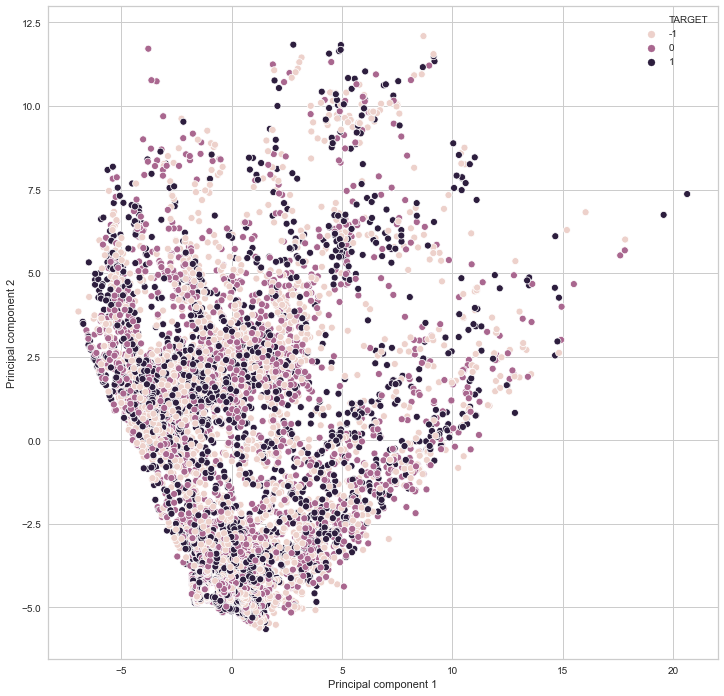

In [35]:
import seaborn as sns
fig = plt.figure(figsize = (12,12))
sns.scatterplot(data=pca_df, x="Principal component 1", y="Principal component 2", hue="TARGET")
plt.show();

In [36]:
ex_variance=np.var(principalComponents,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio 

array([0.51234937, 0.48765063])

 17%|██████████████                                                                      | 1/6 [00:00<00:01,  2.54it/s]

Train scores: 0.3539461725042808
Test scores: 0.3474458575069479


 33%|████████████████████████████                                                        | 2/6 [00:20<00:25,  6.39s/it]

Train scores: 0.37727018104252136
Test scores: 0.3588104660544819


 50%|██████████████████████████████████████████                                          | 3/6 [00:22<00:15,  5.07s/it]

Train scores: 0.5854563075166641
Test scores: 0.3769750216655353


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:23<00:07,  3.70s/it]

Train scores: 1.0
Test scores: 0.3696579193401724


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:24<00:03,  3.02s/it]

Train scores: 0.9712858095847711
Test scores: 0.37005314993404287


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.28s/it]

Train scores: 0.41346546936660483
Test scores: 0.38298937428226243
['LR: 0.347446 (0.017198)', 'SVM: 0.358810 (0.013130)', 'KNN: 0.376975 (0.005374)', 'TREE: 0.369658 (0.005632)', 'FOREST: 0.370053 (0.009431)', 'MLP: 0.374102 (0.009234)']


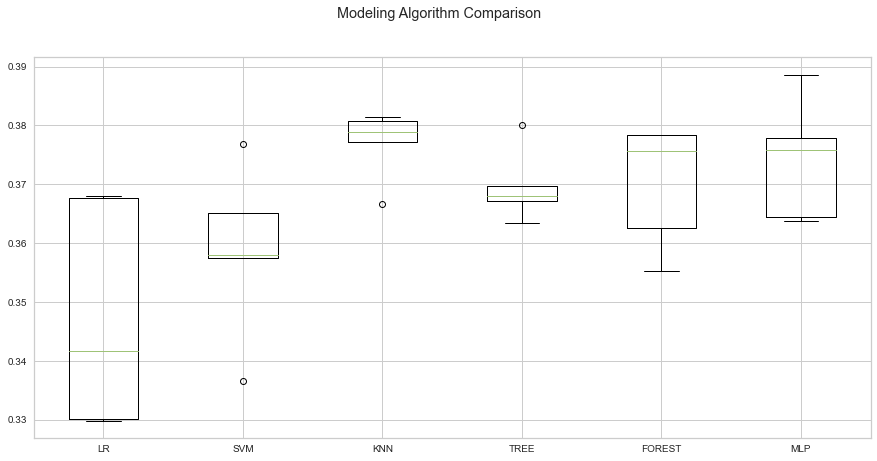

In [37]:
results, names = run_pipelines(pca_df.drop('TARGET', axis=1).values, pca_df.TARGET.values)
logging.info('MODEL-PCA transformed Dataset'.format(len(cols)-4))
logging.info('Results: \n\n{}'.format(results))
logging.info('--------------------------------------------------------------------------------------------------') 

plot_evaluation(results, names)


In [38]:
r = results
n = names
i=0
for j in r:
    global_results_set.append([names[i], j.mean(), trans, cols,'Large number of featureswith PCA','Transformer-4'])
    i=i+1

In [39]:
results=pd.DataFrame(global_results_set, columns=['classifier','scores','transformer','columns','notes','no_model']).sort_values('scores', ascending=False)
results[['classifier','scores','notes','no_model']]

,classifier,scores,notes,no_model
35,MLP,0.693428,Minimum rolling NET FLOWS choice,Transformer-3 Threshold
31,SVM,0.692396,Minimum rolling NET FLOWS choice,Transformer-3 Threshold
18,LR,0.691233,My 1st choice of columns,Transformer-2
6,LR,0.689292,35 features SelectKBest,Transformer-1
12,LR,0.687224,45 features SelectKBest,Transformer-1
30,LR,0.679855,Minimum rolling NET FLOWS choice,Transformer-3 Threshold
34,FOREST,0.670287,Minimum rolling NET FLOWS choice,Transformer-3 Threshold
0,LR,0.662140,20 features SelectKBest,Transformer-1
29,MLP,0.653992,Minimum rolling NET FLOWS choice,Transformer-3 Net Flows
19,SVM,0.644943,My 1st choice of columns,Transformer-2


In [40]:
res_pivot=pd.pivot_table(results, values='scores', index='classifier', columns='no_model', aggfunc=np.max)
res_pivot

no_model,Transformer-1,Transformer-2,Transformer-3 Net Flows,Transformer-3 Threshold,Transformer-4
classifier,,,,,
FOREST,0.581458,0.608999,0.626580,0.670287,0.370053
KNN,0.522237,0.523271,0.568784,0.640415,0.376975
LR,0.689292,0.691233,0.615074,0.679855,0.347446
MLP,0.610551,0.616628,0.653992,0.693428,0.374102
SVM,0.636151,0.644943,0.618823,0.692396,0.358810
TREE,0.579776,0.580939,0.544736,0.584430,0.369658


In [41]:
pd.DataFrame(res_pivot.mean(), columns=['Avg_Score']).reset_index()

,no_model,Avg_Score
0,Transformer-1,0.603244
1,Transformer-2,0.611002
2,Transformer-3 Net Flows,0.604665
3,Transformer-3 Threshold,0.660135
4,Transformer-4,0.366174


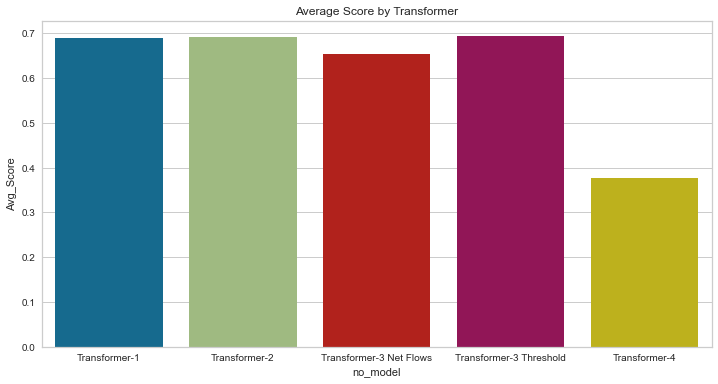

In [42]:
fig = plt.figure(figsize = (12,6))
sns.barplot(x="no_model", y="Avg_Score", data=pd.DataFrame(res_pivot.max(axis=0), columns=['Avg_Score']).reset_index())
plt.title('Average Score by Transformer')
plt.show();

In [43]:
pd.DataFrame(res_pivot.mean(axis=1), columns=['Avg_Score']).reset_index()

,classifier,Avg_Score
0,FOREST,0.571475
1,KNN,0.526336
2,LR,0.604580
3,MLP,0.589740
4,SVM,0.590225
5,TREE,0.531908


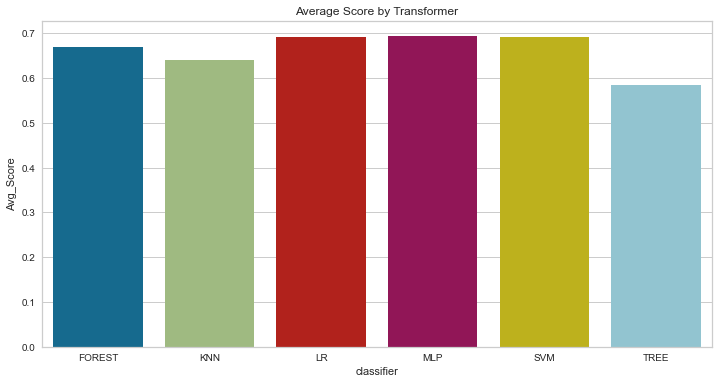

In [44]:
fig = plt.figure(figsize = (12,6))
sns.barplot(x="classifier", y="Avg_Score", data=pd.DataFrame(res_pivot.max(axis=1), columns=['Avg_Score']).reset_index())
plt.title('Average Score by Transformer')
plt.show();

# 1st stage of modeling observation

During this 1st stage I evaluated 4 types of Custom Transformation of the Tise Series dataset to a Supervised Learning dataset.

- (1) - I worked with sklearn SelectKbest features than apply a transformation
- (2) - Based on experience, I selected features which for me are the most relevant in the investment decision
- (3) - I tested the custom transformation on a unique feature (minimum of information)
- (4) - I transformed a lot of quantity of features before applying a dimensionality reduction of 2

I worked with a set of classifier:
- random forest and decision tree
- logistic regression
- support verctor machine
- K-neighbors
- MLP which is a multi-layer perceptron classifier

In terms of <b>transformers</b> the 2nd and 3rd gave the best results. My choice of features based on the knowledge of the area performs well.

For the classifier, I can eliminate the KNN and Decision Tree which gave lowest result. MLP, Support Vector and Random Forest gave an average result of 55%. The best classifier is the Logistic Regression.

The Logistic Regression combined with the 1st (SelectKBest) or 2nd transformer (my choice of features) gave the best score of <b>69%</b>.

## Implement a fine tunning model

In the second part of the modeling process, I will use this result (Logistic Regression with Transformer-2) and fine tune the model with a GridSearch.

The <b>training & validation</b> set will be used to train, score and evaluate the model. The test set will be applied once the best estimator will be find.

## Process
- create the Supervised Learning dataset with the setup of Transformer 2
- split the dataset in training, validation and test set
- create the pipeline of preprocessing and modeling step
- setup the parameter grid
- run the gridsearch to evaluate pipeline on differents parameters
- extract the best score
- get the best estimator
- fine tune the best estimator
- save and apply the test set on the finalized model

In [45]:
# define de columns based on business experience
cols_flows = ['IN_FLOWS', 'OUT_FLOWS','AUM']
cols_perfs = ['BENCH_PERF_SLOPE', 'BENCH_PERF_SLOPE_ERROR',
       'BENCH_VOL_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE',
       'NAV_PERF_SLOPE_ERROR', 'NAV_VOL_SLOPE', 'NAV_VOL_SLOPE_ERROR']
cols_maktg = ['POSITIVE_RFP', 'EVENT_IMPACT', 'DOWNLOADED_DOCUMENTS','PSU_SCORE']
cols_funds = ['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES','RISK_LEVEL_VALUE','STRATEGY_CAPABILITY','FUND_AGE']

all_cols =  cols_flows + cols_perfs + cols_maktg + cols_funds + ['TARGET', 'FLOWS_YEAR', 'FLOWS_MONTH', 'SRC_UID']

# create a X and y vector to pass to the custom transformer
X_final = df[all_cols].drop('TARGET',axis=1)
y_final = df.TARGET

logging.info('Shape of final datatset {} and target {}'.format(X_final.shape, y_final.shape) )
print('Shape of final datatset {} and target {}'.format(X_final.shape, y_final.shape))

Shape of final datatset (8902, 24) and target (8902,)


### Apply the custom transfomation to the final dataset to get the SL
The transformer as a parameter 'interolation' which is True or False. If True, the NaN value are replaced by the transformer by applying pd.interpolate() method. I discovered that keep the rows or dropping the NaN value did not change a lot the pre-modeling result. In this final stage I will drop the rows (which will reduce for each funds the number of observation) but it avoid noisy data.

So, interpolation parameter must be False and I will delete the NaN row afterward.

In [46]:
# create the transformer parameter
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)
    

for i in range(len(cols_perfs)):
    dico= {}
    dico['cols'] = [cols_perfs[i]]
    dico['method'] = 'shift'
    dico['period'] = [2,3,5]
    dico['original'] = False
    trans.append(dico)
    
for i in range(len(cols_maktg)):
    dico= {}
    dico['cols'] = [cols_maktg[i]]
    dico['method'] = 'expanding'
    dico['period'] = [3,6,9]
    dico['original'] = False
    trans.append(dico)

brk='SRC_UID'
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
transform_pipeline = Pipeline(steps)

transformed_final_df = transform_pipeline.fit_transform(X_final, y_final)
# merge the result datsaet with the target value
transformed_final_df = transformed_final_df.merge(df.TARGET, left_index=True, right_index=True)
transformed_final_df.head()

,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,RISK_LEVEL_VALUE,STRATEGY_CAPABILITY,FUND_AGE,FLOWS_YEAR,FLOWS_MONTH,SRC_UID,IN_FLOWS-r2,...,EVENT_IMPACT-x3,EVENT_IMPACT-x6,EVENT_IMPACT-x9,DOWNLOADED_DOCUMENTS-x3,DOWNLOADED_DOCUMENTS-x6,DOWNLOADED_DOCUMENTS-x9,PSU_SCORE-x3,PSU_SCORE-x6,PSU_SCORE-x9,TARGET
0,0,0.000277,0.001631,1,8,14.646575,2010,1,206670688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,0,0.000277,0.001631,1,8,14.723288,2010,2,206670688,79538684.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,0.000277,0.001631,1,8,14.808219,2010,3,206670688,78746186.5,...,0.00,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,-1
3,0,0.000277,0.001631,1,8,14.890411,2010,4,206670688,86431670.0,...,0.25,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1
4,0,0.000277,0.001631,1,8,14.975342,2010,5,206670688,85148405.5,...,0.20,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,-1


In [47]:
transformed_final_df.dropna(inplace=True)
transformed_final_df.shape, X_final.shape, 'rows deleted =', X_final.shape[0]-transformed_final_df.shape[0]

((8254, 55), (8902, 24), 'rows deleted =', 648)

In [48]:
# create a sweeviz (EDA vizualization of the final dataset)
# no need to include the SRC_UID which is a foreign key and define the traget 
from shutil import copyfile
feature_config = sv.FeatureConfig(skip="SRC_UID", force_num=["TARGET"])
my_report = sv.analyze(transformed_final_df, feat_cfg=feature_config, target_feat='TARGET')
my_report.show_html(open_browser=False) 


# save the report on another name
copyfile('SWEETVIZ_REPORT.html','sweetviz/sw_final_SL_datatset.html')


Report SWEETVIZ_REPORT.html was generated.


'sweetviz/sw_final_SL_datatset.html'

### Split the dataset in training, validation and test


In [49]:
X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(transformed_final_df)

X_train, X_validation, y_train, y_validation = train_test_split(X_trainval, y_trainval, 
                                                                test_size=0.33, random_state=42, 
                                                                stratify=y_trainval )
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)


(5018, 54) (5018,) (2473, 54) (2473,) (763, 54) (763,)


### Define the pipeline
I will add the scalling process and power transformation and the Logistic Regression classifier.
Parameter will be set in the grid parameter.

In [68]:
pipe_steps =[('Scaler', StandardScaler()),
             ('Power', PowerTransformer()),
    ('LR',LogisticRegression(random_state=42, max_iter=1000))]

params = {
    'LR__C':[100,1000,10000],
    'LR__solver':['newton-cg','liblinear','lbfgs'],#
    'LR__class_weight':[None,'balanced'],
    # 'LR__multi_class':['auto','ovr']
}

pipeline = Pipeline(pipe_steps)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   48.2s finished


2 0.6959158916295997
{'LR__C': 100, 'LR__class_weight': 'balanced', 'LR__solver': 'newton-cg'}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.2min finished


5 0.6975333602911443
{'LR__C': 10000, 'LR__class_weight': 'balanced', 'LR__solver': 'newton-cg'}
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  9.6min finished


10 0.6955115244642135
{'LR__C': 100, 'LR__class_weight': 'balanced', 'LR__solver': 'lbfgs'}

Confusion Matrix

[[629 121  83]
 [212 460 167]
 [ 65 105 631]]

Accuracy: 0.70

Micro Precision: 0.70
Micro Recall: 0.70
Micro F1-score: 0.70

Macro Precision: 0.69
Macro Recall: 0.70
Macro F1-score: 0.69

Weighted Precision: 0.69
Weighted Recall: 0.70
Weighted F1-score: 0.69

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.69      0.76      0.72       833
NeutralFlows       0.67      0.55      0.60       839
    In Flows       0.72      0.79      0.75       801

   micro avg       0.70      0.70      0.70      2473
   macro avg       0.69      0.70      0.69      2473
weighted avg       0.69      0.70      0.69      2473



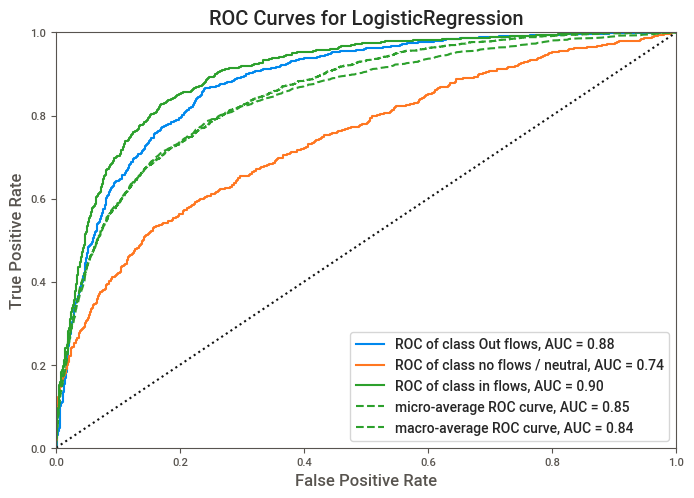

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
    binary=None, classes=None,
    encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
    estimator=Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Power', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('LR', LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
    force_model=False, is_fitted='auto', macro=True, micro=True,
    per_class=True)

In [69]:
from tqdm import tqdm_notebook as tqdm_final
for cv in tqdm_final([2,5,10]):
    grid = GridSearchCV(pipeline, param_grid = params,  cv=cv, verbose=1)
    grid.fit(X_train, y_train)
    print(cv, grid.score(X_validation, y_validation))
    print(grid.best_params_)
    
# get the best estimator
best_estimator = grid.best_estimator_

# compute prediction on the validation set
y_pred = best_estimator.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)

# plot a ROC Curve
plot_ROC_curve(best_estimator, X_train, y_train, X_validation, y_validation)

In [54]:
clf = best_estimator
best_estimator.fit(X_trainval, y_trainval)

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Power', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('LR', LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [55]:
# compute the probability on the test set

clf_probs = clf.predict_proba(X_test)
clf_probs

array([[3.08020764e-01, 3.73771998e-01, 3.18207238e-01],
       [3.06691920e-01, 3.64297008e-01, 3.29011072e-01],
       [2.62386326e-01, 3.60684908e-01, 3.76928766e-01],
       ...,
       [1.68830835e-03, 4.64144111e-01, 5.34167581e-01],
       [2.33927429e-04, 4.29027498e-01, 5.70738575e-01],
       [1.14509642e-04, 4.35401411e-01, 5.64484079e-01]])

In [56]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
clf_probs[:2]

array([[0.308, 0.374, 0.318],
       [0.307, 0.364, 0.329]])

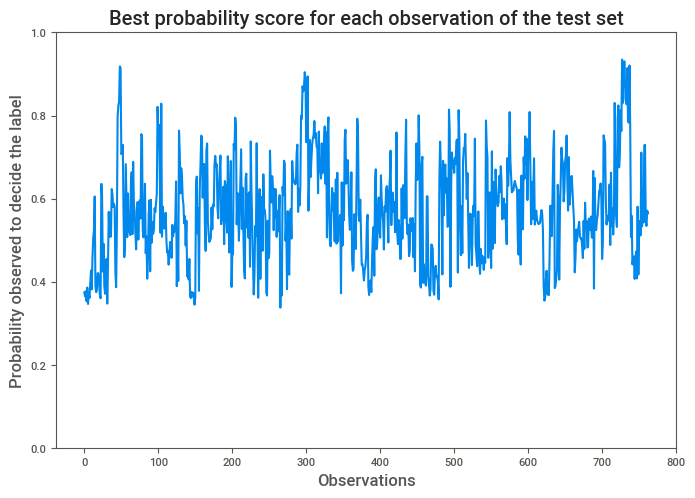

Probability are centered around 0.5-0.6


In [57]:
ind=list(range(0, len(clf_probs)))
plt.plot(clf_probs[ind,np.argmax(clf_probs, axis=1)])
plt.title('Best probability score for each observation of the test set')
plt.xlabel('Observations')
plt.ylabel('Probability observed to decide the label')
plt.ylim(0, 1)
plt.show();
print('Probability are centered around 0.5-0.6')

# OBSERVATIONS ON THE FINE TUNNING
I decided to keep the Logistic Regression as a choice. Best results seems to be with <b>{'LR__C': 100, 'LR__class_weight': 'balanced', 'LR__solver': 'lbfgs'}</b> parameter.
To finalize my project, I will create a unique model with these parameters and include the Custom Transformer in the pipeline.
The model will be save so it can be reused in another notebook.

With my method of wrapping my Custom Transformer, I can create several models depending on the features I want to include. My main model will be with the columns fo my choice decided in exploration n° 2 (I just renamed the list to 'cols_shift, cols_rolling, ....' which contain columns for named method).

I will show another example of saved model with 3 features only.

# FINALIZING THE MODEL

In [58]:
class TS2SL(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, transformation=None):

        self.cols=cols
        self.transformation=transformation
        
    #def preprocess_f(self, X_df, train_mean):
    def preprocess_f(self, X_df):
        # Work on a copy
        #print(X_df.columns)
        if 'TARGET' in X_df.columns:
            X_df = X_df[self.cols].copy()
        else:
            temp=self.cols
            try:
                temp.remove('TARGET')
            except:
                X_df = X_df[temp].copy()            
        b_breakdown = np.unique(X_df['SRC_UID'])
        # Missing values in continuous features
        for trans in tqdm_final(self.transformation):
            dico = trans
            for i, (k, v) in enumerate(dico.items()):
                logging.info('index {} - dico value for key {} is {}'.format(i, k, v))            
                # enumerate dictionary key and value

            for b in b_breakdown:
                f=X_df['SRC_UID']==b
                all_cols = dico['cols'].copy()

                for col in all_cols:
                    for p in dico['period']:
                        #print('change ',col,'p=',p)
                        if dico['method']=='shift':   
                            m='s'
                            X_df.loc[f,col+'_s_'+str(p)]=X_df.loc[f,col].shift(periods=p)
                        if dico['method']=='rolling': 
                            m='r'
                            X_df.loc[f,col+'_r_'+str(p)]=X_df.loc[f,col].rolling(p).mean()
                        if dico['method']=='expanding':   
                            m='x'
                            X_df.loc[f,col+'_x_'+str(p)]=X_df.loc[f,col].expanding(min_periods=p).mean()
                        if dico['method']=='ewm':  
                            m='e'
                            X_df.loc[f,col+'_e_'+str(p)]=X_df.loc[f,col].ewm(com=p).mean()


                        X_df.loc[f,col+'_'+m+'_'+str(p)]=X_df.loc[f,col+'_'+m+'_'+str(p)].interpolate(limit_direction='both')    

            for c in all_cols:
                X_df.drop(c,axis=1,inplace=True)
                
        if 'TARGET' in X_df.columns:
            X_df.drop('TARGET',axis=1,inplace=True)

        
        logging.info('return X_df'.format(X_df.shape))
        return X_df.fillna(0)

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        
        assert type(X_df) == pd.DataFrame
        logging.info('arriving in fit'.format(X_df.shape))
        print('arriving in fit {}'.format(X_df.shape))
        
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame
        print('entering in transform {}'.format(X_df.shape))
        # Preprocess data

        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)

        return X_reindexed

In [59]:
def final_model(cols_rolling,cols_shift,cols_ewm,cols_expanding):


    cols_funds = ['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES','RISK_LEVEL_VALUE','STRATEGY_CAPABILITY','FUND_AGE']


    all_cols =  cols_rolling + cols_shift + cols_ewm + cols_expanding + cols_funds + ['TARGET', 'FLOWS_YEAR', 'FLOWS_MONTH', 'SRC_UID']
    # create the transformer parameter
    trans = []
    for i in range(len(cols_rolling)):
        dico= {}
        dico['cols'] = [cols_rolling[i]]
        dico['method'] = 'rolling'
        dico['period'] = [2,3,4]
        dico['original'] = False
        trans.append(dico)


    for i in range(len(cols_shift)):
        dico= {}
        dico['cols'] = [cols_shift[i]]
        dico['method'] = 'shift'
        dico['period'] = [1,2,3]
        dico['original'] = False
        trans.append(dico)

    for i in range(len(cols_ewm)):
        dico= {}
        dico['cols'] = [cols_ewm[i]]
        dico['method'] = 'ewm'
        dico['period'] = [1,3,6]
        dico['original'] = False
        trans.append(dico)


    for i in range(len(cols_expanding)):
        dico= {}
        dico['cols'] = [cols_expanding[i]]
        dico['method'] = 'ewm'
        dico['period'] = [1,3,6]
        dico['original'] = False
        trans.append(dico)    

    c=all_cols
    # Use our custom transformer in a pipeline
    pipe = Pipeline([
        ('preprocessor', TS2SL(cols=c, transformation=trans)),
        ('Scaler', StandardScaler()), ('Power', PowerTransformer()),
        ('LR', LogisticRegression(C=1000,solver='lbfgs',class_weight='balanced', max_iter=1000))
    ])


    f=df['FLOWS_YEAR']<2020
    # Split data
    #X = df[c].drop('TARGET', axis=1)
    X = df.loc[f,c]
    y = df.loc[f,'TARGET']
    
    transformed_final_df=df[c].copy()

    X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval = split_dataset(transformed_final_df)

    X_train, X_validation, y_train, y_validation = train_test_split(X_trainval, y_trainval, 
                                                                    test_size=0.33, random_state=42, 
                                                                    stratify=y_trainval )
    
    print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

    f=df['FLOWS_YEAR']>2019
    # Split data
    #X = df[c].drop('TARGET', axis=1)
    X_test = df.loc[f,c]
    y_test = df.loc[f,'TARGET']

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)

    # Evaluate estimator
    pipe.fit(X_train, y_train)

    print(pipe.score(X_validation, y_validation), X_validation.shape, y_validation.shape)

    # compute prediction on the validation set
    y_pred = pipe.predict(X_test)


    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    accuracy_score(y_test, y_pred)
    target_names = ['Out Flows', 'Neutral', 'In Flows']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    return pipe, X_test, y_test

In [60]:
# define de columns based on business experience
cols_rolling = ['NAV_VOL_SLOPE', 'NAV_PERF_SLOPE','BENCH_PERF_SLOPE',
                'BENCH_VOL_SLOPE','AUM','NET_FLOWS','IN_FLOWS','OUT_FLOWS'] 
cols_shift = [ 'BENCH_PERF_SLOPE_ERROR',
        'BENCH_VOL_SLOPE_ERROR',
       'NAV_PERF_SLOPE_ERROR',  'NAV_VOL_SLOPE_ERROR']
cols_ewm = ['POSITIVE_RFP', 'EVENT_IMPACT', 'DOWNLOADED_DOCUMENTS','PSU_SCORE']
cols_expanding = []

p, x_te, y_te=final_model(cols_rolling,cols_shift,cols_ewm,cols_expanding)

# compute prediction on the validation set
y_pred = p.predict(x_te)
acc, conf = metrics_report(y_te, y_pred)

# save the model to disk
filename = 'models/finalized_model.sav'
pickle.dump(p, open(filename, 'wb'))

(5453, 25) (5453,) (2686, 25) (2686,) (763, 25) (763,)
arriving in fit (5453, 26)



entering in transform (5453, 26)



entering in transform (2686, 26)



0.620253164556962 (2686, 26) (2686,)
entering in transform (763, 26)



              precision    recall  f1-score   support

   Out Flows       0.65      0.71      0.68       243
     Neutral       0.62      0.72      0.67       293
    In Flows       0.84      0.57      0.68       227

   micro avg       0.67      0.67      0.67       763
   macro avg       0.70      0.67      0.67       763
weighted avg       0.69      0.67      0.67       763

entering in transform (763, 26)



Confusion Matrix

[[173  63   7]
 [ 63 212  18]
 [ 30  68 129]]

Accuracy: 0.67

Micro Precision: 0.67
Micro Recall: 0.67
Micro F1-score: 0.67

Macro Precision: 0.70
Macro Recall: 0.67
Macro F1-score: 0.67

Weighted Precision: 0.69
Weighted Recall: 0.67
Weighted F1-score: 0.67

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.65      0.71      0.68       243
NeutralFlows       0.62      0.72      0.67       293
    In Flows       0.84      0.57      0.68       227

   micro avg       0.67      0.67      0.67       763
   macro avg       0.70      0.67      0.67       763
weighted avg       0.69      0.67      0.67       763



In [61]:
# define de columns based on business experience
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore', category=DataConversionWarning)

cols_rolling = ['AUM','NET_FLOWS'] 
cols_shift = [ ]
cols_ewm = ['POSITIVE_RFP']
cols_expanding = []

p, x_te, y_te=final_model(cols_rolling,cols_shift,cols_ewm,cols_expanding)

# compute prediction on the validation set
y_pred = p.predict(x_te)
acc, conf = metrics_report(y_te, y_pred)

# save the model to disk
filename = 'models/short_model_aum_netflows_rfp.sav'
pickle.dump(p, open(filename, 'wb'))

(5453, 12) (5453,) (2686, 12) (2686,) (763, 12) (763,)
arriving in fit (5453, 13)



entering in transform (5453, 13)



entering in transform (2686, 13)



0.5774385703648548 (2686, 13) (2686,)
entering in transform (763, 13)



              precision    recall  f1-score   support

   Out Flows       0.63      0.67      0.65       243
     Neutral       0.56      0.66      0.61       293
    In Flows       0.79      0.56      0.65       227

   micro avg       0.63      0.63      0.63       763
   macro avg       0.66      0.63      0.64       763
weighted avg       0.65      0.63      0.63       763

entering in transform (763, 13)



Confusion Matrix

[[163  74   6]
 [ 72 193  28]
 [ 23  77 127]]

Accuracy: 0.63

Micro Precision: 0.63
Micro Recall: 0.63
Micro F1-score: 0.63

Macro Precision: 0.66
Macro Recall: 0.63
Macro F1-score: 0.64

Weighted Precision: 0.65
Weighted Recall: 0.63
Weighted F1-score: 0.63

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.63      0.67      0.65       243
NeutralFlows       0.56      0.66      0.61       293
    In Flows       0.79      0.56      0.65       227

   micro avg       0.63      0.63      0.63       763
   macro avg       0.66      0.63      0.64       763
weighted avg       0.65      0.63      0.63       763

